In [7]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt


# Get utils.py
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
# download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params

set_pyplot_params()

from utils import Or70, Pu50, Gr30

color_list3 = [Or70, Pu50, Gr30]

import matplotlib.pyplot as plt
from cycler import cycler

marker_cycle = cycler(marker=['s', 'o', '^'])
color_cycle = cycler(color=color_list3)
line_cycle = cycler(linestyle=['-', '--', ':'])

plt.rcParams['axes.prop_cycle'] = (color_cycle + 
                                   marker_cycle + 
                                   line_cycle)

# Load the data files from 
# https://github.com/allisonhorst/palmerpenguins
# With gratitude to Allison Horst (@allison_horst)

# download('https://github.com/allisonhorst/palmerpenguins/raw/main/inst/extdata/penguins_raw.csv')

In [2]:
df = pd.read_csv('penguins_raw.csv').dropna(subset=['Body Mass (g)'])
def shorten(species):
    return species.split()[0]

df['Species2'] = df['Species'].apply(shorten)
X = df[['Culmen Length (mm)', 'Flipper Length (mm)']]
y = df['Species2']
y, species = pd.factorize(df['Species2'], sort = True)

In [31]:
with pm.Model() as model:
    # 데이터 컨테이너 설정
    X_data = pm.Data('X_data', X)
    y_data = pm.Data('y_data', y)    
    # Y의 사전확률을 베타분포로 설정
    alpha = np.ones(3)
    p = pm.Dirichlet('p', alpha)
    # Y의 베르누이 분포
    z = pm.Categorical('z', p, observed=y_data, shape = X_data.shape[0])
    
    # 각 클래스 및 특징(평균, 표준편차)에 대한 조건부 분포 설정
    mus = pm.Normal('mus', mu=0, sigma=10, shape=(3, 2))  
    sigmas = pm.HalfNormal('sigmas', sigma=1, shape=(3, 2))
    
    # 특징 데이터의 조건부 분포: Y에 따라 평균과 표준편차 선택
    X_obs = pm.Normal('X_obs'
                        , mu=mus[z]
                        , sigma=sigmas[z]
                        , observed=X_data)
    trace = pm.sample(500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, mus, sigmas]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mus[0, 0]",38.774,0.211,38.381,39.175,0.004,0.003,3313.0,1446.0,1.00
"mus[0, 1]",189.519,0.487,188.663,190.500,0.007,0.005,4339.0,1628.0,1.00
"mus[1, 0]",48.766,0.403,47.958,49.473,0.006,0.004,4087.0,1423.0,1.00
"mus[1, 1]",194.824,0.730,193.352,196.059,0.011,0.008,4132.0,1627.0,1.00
"mus[2, 0]",47.464,0.270,46.976,47.982,0.004,0.003,5227.0,1240.0,1.00
"mus[2, 1]",216.588,0.509,215.664,217.567,0.008,0.006,4232.0,1575.0,1.00
p[0],0.440,0.027,0.385,0.484,0.001,0.000,2444.0,1701.0,1.00
p[1],0.200,0.021,0.163,0.242,0.000,0.000,3283.0,1696.0,1.00
p[2],0.360,0.026,0.312,0.410,0.001,0.000,2250.0,1457.0,1.00
"sigmas[0, 0]",2.627,0.139,2.375,2.888,0.002,0.002,4119.0,1682.0,1.01


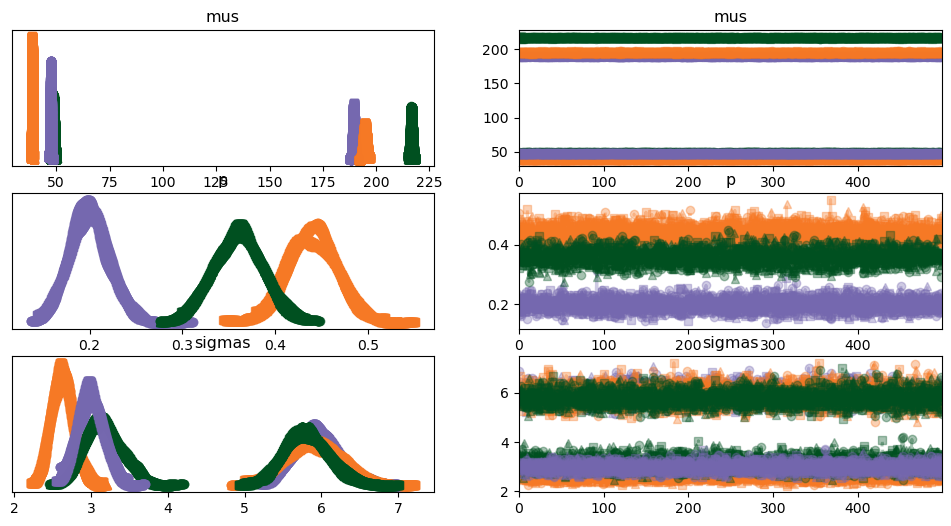

In [15]:
az.plot_trace(trace)
az.summary(trace)

In [16]:
X

,Culmen Length (mm),Flipper Length (mm)
0,39.1,181.0
1,39.5,186.0
2,40.3,195.0
4,36.7,193.0
5,39.3,190.0
...,...,...
339,55.8,207.0
340,43.5,202.0
341,49.6,193.0
342,50.8,210.0


In [32]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [47]:
new_X = np.array([[30, 180], [50, 190], [40, 180], [50, 180]])
with model:
    pm.set_data({'X_data': new_X, 'y_data': [0] * new_X.shape[0]})
    post_trace = pm.sample_posterior_predictive(trace)

Sampling: [X_obs, z]


Output()

In [50]:
post_trace.posterior_predictive.z.mean(dim=['chain', 'draw'])

<xarray.DataArray 'z' (z_dim_2: 4)> Size: 32B
array([0.931, 0.905, 0.926, 0.91 ])
Coordinates:
  * z_dim_2  (z_dim_2) int64 32B 0 1 2 3

In [38]:
post_trace

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data